<a href="https://colab.research.google.com/github/akhaire21/Semi-Supervised-Ensemble-Model/blob/main/Microglia_AD_Research_PUNULearningModel_FinalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Model Input File

In [1]:
from google.colab import drive
import pandas as pd

drive = drive.mount('/content/drive/')
df=pd.read_csv('/content/drive/My Drive/Regeneron_STS_2023/Model/Input_Data/SSL_PUNU_Model_Input_Final.txt',header=0, sep='\t')
df.head()

Mounted at /content/drive/


,chr,start,end,Target,xc119_TPM,xc120_TPM,cnt,expected,Nreads,score,score_ATAC_wtcMG,score_chip_invitro,score_chip_exvivo,score_atac_exvivo,score_atac_invitro,eQTL_flg
0,chr1,916549,916550,-1,0.00,0.00,0.0,0.000000,0.0,0.00,0.066223,0.00000,0.0,0.034954,0.000000,0
1,chr1,961827,961828,-1,20.37,18.24,11.0,2.431481,6.8,8.67,0.110371,0.00000,0.0,0.069908,0.050722,0
2,chr1,963249,963250,-1,20.37,18.24,11.0,2.431481,6.8,8.67,0.066223,0.03043,0.0,0.034954,0.101443,0
3,chr1,971224,971225,-1,20.37,18.24,0.0,0.000000,6.8,8.67,0.154519,0.00000,0.0,0.139816,0.000000,0
4,chr1,972134,972135,-1,20.37,18.24,0.0,0.000000,6.8,8.67,0.033111,0.03043,0.0,0.000000,0.000000,0


# Data Prep

In [2]:
import numpy as np

df_N = df[['xc119_TPM','xc120_TPM','cnt','expected','Nreads','score',
           'score_ATAC_wtcMG','score_chip_invitro','score_chip_exvivo',
           'score_atac_exvivo','score_atac_invitro','eQTL_flg','Target']].copy()
df_N['index1'] = df_N.index           
df_N.replace(to_replace=[None], value=np.nan, inplace=True)
df_N = df_N.fillna(0.)

df_N['cnt_ovr_exptd'] = (df_N['cnt'] / df_N['expected']).replace(np.inf, np.nan)
df_N = df_N.fillna(0.)
df_N.pop('cnt')
df_N.pop('expected')

df_N.head(5)

,xc119_TPM,xc120_TPM,Nreads,score,score_ATAC_wtcMG,score_chip_invitro,score_chip_exvivo,score_atac_exvivo,score_atac_invitro,eQTL_flg,Target,index1,cnt_ovr_exptd
0,0.00,0.00,0.0,0.00,0.066223,0.00000,0.0,0.034954,0.000000,0,-1,0,0.000000
1,20.37,18.24,6.8,8.67,0.110371,0.00000,0.0,0.069908,0.050722,0,-1,1,4.523992
2,20.37,18.24,6.8,8.67,0.066223,0.03043,0.0,0.034954,0.101443,0,-1,2,4.523992
3,20.37,18.24,6.8,8.67,0.154519,0.00000,0.0,0.139816,0.000000,0,-1,3,0.000000
4,20.37,18.24,6.8,8.67,0.033111,0.03043,0.0,0.000000,0.000000,0,-1,4,0.000000


In [3]:
print(df_N['Target'].value_counts())

-1    47702
 1       14
 2       14
Name: Target, dtype: int64


In [4]:
## Drop Negative Labels to convert data into PU-Learning Dataset
mod_data = df_N[df_N['Target'] != 2].copy()

mod_data = mod_data[['xc119_TPM','xc120_TPM','cnt_ovr_exptd','Nreads','score',
                 'score_ATAC_wtcMG','score_chip_invitro','score_chip_exvivo',
                 'score_atac_exvivo','score_atac_invitro','eQTL_flg','index1','Target']].copy()
print(mod_data['Target'].value_counts())

-1    47702
 1       14
Name: Target, dtype: int64


In [5]:
x_data = mod_data.iloc[:,:-2].values # X  : 47716 x 11
y_labeled = mod_data.iloc[:,-1].values # just the P Labels : 47716 x 1

data_P = x_data[y_labeled==1]  # 14 x 11
data_U = x_data[y_labeled==-1]  # 47702 x 11

In [6]:
mod_data.iloc[:,:-2].head(1)

,xc119_TPM,xc120_TPM,cnt_ovr_exptd,Nreads,score,score_ATAC_wtcMG,score_chip_invitro,score_chip_exvivo,score_atac_exvivo,score_atac_invitro,eQTL_flg
0,0.0,0.0,0.0,0.0,0.0,0.066223,0.0,0.0,0.034954,0.0,0


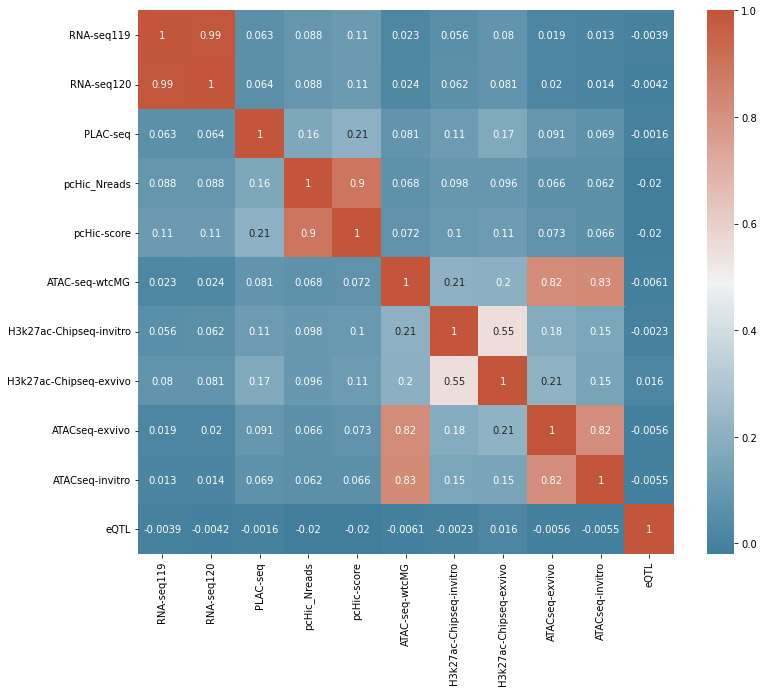

In [7]:
import seaborn as sns
import matplotlib.pyplot as mp
mp.figure(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fea = mod_data.iloc[:,:-2].copy()
fea.columns = ['RNA-seq119','RNA-seq120','PLAC-seq','pcHic_Nreads',
                'pcHic-score','ATAC-seq-wtcMG','H3k27ac-Chipseq-invitro',
                'H3k27ac-Chipseq-exvivo','ATACseq-exvivo','ATACseq-invitro','eQTL']
#dataplot=sns.heatmap(mod_data.iloc[:,:-2].corr(), cmap=cmap,annot=True)
dataplot=sns.heatmap(fea.corr(), cmap=cmap,annot=True)
mp.show()

# Bagging Classifier Ensemble Model Function

In [8]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 14.4 MB/s 
     |████████████████████████████████| 133 kB 57.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=78ef5c3af217527a4cb72b3b55f98266a55d1ca60fc4c2f1db69c29799779115
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [9]:
## Classifier with bootstrap bagging ensemble method
## Step 1: PU learning : Classifier trained on all P-labeled, and subset of Unlabeled data
## Step 2: Transductive Bagging : Classifier then scores out-of-the-bag (oob) samples.
## Predictions are averaged to transduce the labels.
import eli5
from eli5.sklearn import PermutationImportance

def Bagging_classifier_ensemble(T,NU, K, dataP, dataU, trainL):
  for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)

    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((dataP, dataU[bootstrap_sample, :]), axis=0)

    # Train model
    model.fit(data_bootstrap, trainL)

    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))

    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(dataU[idx_oob])
    n_oob[idx_oob] += 1

    # Feature Importance
    perm = PermutationImportance(model).fit(data_bootstrap, trainL)
    perm_ar = eli5.explain_weights_df(perm)
    perm_ar['re'] = perm_ar['feature'].str[1:].astype(int)
    perm_ar = perm_ar.sort_values('re')
    perm_ar = perm_ar.drop(columns=['re'])
    perm_ar = perm_ar.values
    n_fea[:,0] = (np.add(n_fea[:,0], perm_ar[:,1]))
    n_fea[:,1] = (np.add(n_fea[:,1], perm_ar[:,2])) 

    if i%500 == 0:
      print('Bootstrap resample# ::', i)

  predict_proba = f_oob/n_oob[:,None]
  feature_imp = n_fea / T

  return predict_proba, feature_imp

# Model Definitions

In [10]:
from sklearn.tree import DecisionTreeClassifier  ## Decision Tree
from sklearn.ensemble import RandomForestClassifier ## Random Forest
from sklearn.neural_network import MLPClassifier ## Neural Network
from sklearn.svm import SVC  ## Support Vector Classification
from xgboost import XGBClassifier  ## XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier ## Voting Ensemble: Soft Voting

from pandas.io.parsers.python_parser import Iterator
from pandas.core.series import Iterable

## Decision Tree
DT = DecisionTreeClassifier(max_depth=None, max_features=None, criterion='gini', random_state=0, class_weight='balanced')

## Random Forest
RF = RandomForestClassifier(n_estimators = 100, max_depth=None,max_features=None,random_state=0,
                               criterion='gini',class_weight='balanced', bootstrap=False)

## Neural Network
NNMLP = MLPClassifier(hidden_layer_sizes = (18, 18), max_iter = 5000)   


## XGBoost with "binary:logistic" objective to achieve clear distinction between positive, and unrecognizable label class
XGB = XGBClassifier(objective='binary:logistic',seed=42)

##Logistic Regression
LR = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state=0)

## Voting Ensemble: Soft Voting
VT = VotingClassifier(estimators=[('DT', DT), ('RF', RF), ('NNMLP', NNMLP), ('XGB', XGB), ('LR', LR)], voting='soft')


## Model Selection
models = [DT, RF, NNMLP, XGB, LR, VT]
#models = [DT]


# Model Execution

In [ ]:
Iterations = 1  # Iterations to overcome the stochastic nature of classifier
T = 500        # Nnumber of draws in random sampling with replacement.

NP = data_P.shape[0]  # Number of Positive labels
NU = data_U.shape[0]  # Number of Unknown Labels

K = NP    #number of labeled samples, Same as labeled samples 

## Training Labels
## 0 : Unlabeled Records , 1 : Positive Labels
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0

df_prob_list = []
df_feature_list = []

for model in models:
  print('Starting Model: ', model)
  n_fea = np.zeros(shape=(11,2))  
  n_oob = np.zeros(shape=(NU,))
  f_oob = np.zeros(shape=(NU, 2)) 
  prob_total = np.zeros(shape=(NU,2)) 
  feature_total = np.zeros(shape=(11,2))  

  for i in range(Iterations):
    print('Iteration:', i)

    df_prob, df_feature = Bagging_classifier_ensemble(T,NU, K, data_P, data_U, train_label)

    prob_total = (np.add(prob_total, df_prob)) 
    prob_avg = prob_total / (i+1)

    feature_total = (np.add(feature_total, df_feature))
    feature_avg = feature_total / (i+1)

  df_prob = pd.DataFrame(prob_avg)
  df_prob_list.append(df_prob)

  df_feature = pd.DataFrame(feature_avg)
  feature_names = mod_data.iloc[:,:-2].columns
  df_feature_name = pd.DataFrame(feature_names)
  df_feature = pd.concat([df_feature_name, df_feature.reindex(df_feature_name.index)], axis=1)
  df_feature_list.append(df_feature)

  ## Write model predictions dataframe to csv
  modelname = str(model).split('(')[0]
  #filename = '/content/drive/My Drive/Regeneron_STS_2023/Model/PU_predictions_' + modelname + '.txt'
  #print(filename)
  #df_prob.to_csv(filename, sep='\t',index=False)
  #print('----------------------------')

  ## Write final dataframe to csv
  df_f = pd.concat(df_feature_list, axis=1)
  #filename = '/content/drive/My Drive/Regeneron_STS_2023/Model/PU_feature_importance_' + modelname + '.txt'
  #print(filename)
  #df_f.to_csv(filename, sep='\t',index=False)

Starting Model:  DecisionTreeClassifier(class_weight='balanced', random_state=0)
Iteration: 0
Bootstrap resample# :: 0
Starting Model:  RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features=None, random_state=0)
Iteration: 0
Bootstrap resample# :: 0
Starting Model:  MLPClassifier(hidden_layer_sizes=(18, 18), max_iter=5000)
Iteration: 0
Bootstrap resample# :: 0
Starting Model:  XGBClassifier(seed=42)
Iteration: 0
Bootstrap resample# :: 0
Starting Model:  LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
Iteration: 0
Bootstrap resample# :: 0
Starting Model:  VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     random_state=0)),
                             ('RF',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight='balance

# PU Predictions Processing

In [11]:
from google.colab import drive
import pandas as pd

drive = drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
model_pred = [
'PU_predictions_DecisionTreeClassifier.txt',
'PU_predictions_RandomForestClassifier.txt',
'PU_predictions_MLPClassifier.txt',
'PU_predictions_XGBClassifier.txt',
'PU_predictions_LogisticRegression.txt',
'PU_predictions_VotingClassifier.txt'
]

df_prob_list = []
for pred in model_pred:
  filename = '/content/drive/My Drive/Regeneron_STS_2023/Model/' + pred
  df = pd.read_csv(filename,delimiter='\t')
  df_prob_list.append(df)

In [13]:
df_prob_list

[              0         1
 0      0.966464  0.033536
 1      0.203965  0.796035
 2      0.532407  0.467593
 3      0.243393  0.756607
 4      0.694012  0.305988
 ...         ...       ...
 47697  1.000000  0.000000
 47698  0.884466  0.115534
 47699  0.871020  0.128980
 47700  0.999291  0.000709
 47701  0.999972  0.000028
 
 [47702 rows x 2 columns],               0         1
 0      0.969268  0.030732
 1      0.215121  0.784879
 2      0.498991  0.501009
 3      0.279508  0.720492
 4      0.667829  0.332171
 ...         ...       ...
 47697  0.999996  0.000004
 47698  0.878041  0.121959
 47699  0.860775  0.139225
 47700  0.999411  0.000589
 47701  0.999916  0.000084
 
 [47702 rows x 2 columns],               0         1
 0      0.864319  0.135681
 1      0.532603  0.467397
 2      0.534604  0.465396
 3      0.360064  0.639936
 4      0.390188  0.609812
 ...         ...       ...
 47697  0.917491  0.082509
 47698  0.785584  0.214416
 47699  0.897532  0.102468
 47700  0.916477  0.083523

In [14]:
## Flatten the df_prob_list - list of probability dataframes for all models
all_predicted_proba = pd.concat(df_prob_list, axis=1)
all_predicted_proba.head()

,0,1,0,1,0,1,0,1,0,1,0,1
0,0.966464,0.033536,0.969268,0.030732,0.864319,0.135681,0.869627,0.130373,0.874896,0.125104,0.907939,0.092061
1,0.203965,0.796035,0.215121,0.784879,0.532603,0.467397,0.185334,0.814666,0.396027,0.603973,0.304934,0.695066
2,0.532407,0.467593,0.498991,0.501009,0.534604,0.465396,0.454419,0.545581,0.397733,0.602267,0.482295,0.517705
3,0.243393,0.756607,0.279508,0.720492,0.360064,0.639936,0.305440,0.694560,0.228201,0.771799,0.285408,0.714592
4,0.694012,0.305988,0.667829,0.332171,0.390188,0.609812,0.741196,0.258804,0.248714,0.751286,0.549146,0.450854


In [15]:
del df_prob_list

In [16]:
cols = []
for model in models:
  modelname = str(model).split('(')[0]
  #print(modelname)
  cols.append(modelname + '_prob_0')
  cols.append(modelname + '_prob_positive')

all_predicted_proba.columns = cols
all_predicted_proba.head()

,DecisionTreeClassifier_prob_0,DecisionTreeClassifier_prob_positive,RandomForestClassifier_prob_0,RandomForestClassifier_prob_positive,MLPClassifier_prob_0,MLPClassifier_prob_positive,XGBClassifier_prob_0,XGBClassifier_prob_positive,LogisticRegression_prob_0,LogisticRegression_prob_positive,VotingClassifier_prob_0,VotingClassifier_prob_positive
0,0.966464,0.033536,0.969268,0.030732,0.864319,0.135681,0.869627,0.130373,0.874896,0.125104,0.907939,0.092061
1,0.203965,0.796035,0.215121,0.784879,0.532603,0.467397,0.185334,0.814666,0.396027,0.603973,0.304934,0.695066
2,0.532407,0.467593,0.498991,0.501009,0.534604,0.465396,0.454419,0.545581,0.397733,0.602267,0.482295,0.517705
3,0.243393,0.756607,0.279508,0.720492,0.360064,0.639936,0.305440,0.694560,0.228201,0.771799,0.285408,0.714592
4,0.694012,0.305988,0.667829,0.332171,0.390188,0.609812,0.741196,0.258804,0.248714,0.751286,0.549146,0.450854


In [17]:
## Create final dataframe by joining fattened probabilities frame to original input dataset
df=pd.read_csv('/content/drive/My Drive/Regeneron_STS_2023/Model/Input_Data/SSL_PUNU_Model_Input_Final.txt',header=0, sep='\t')

tmp1 = mod_data[mod_data['Target']==-1][['index1']].copy()
tmp1.reset_index(drop=True, inplace=True)
tmp2 = mod_data.loc[~mod_data['index1'].isin(tmp1['index1'])][['index1']].copy()
dp = all_predicted_proba.copy()
dp.reset_index(drop=True, inplace=True)
tmp1[ list(dp.columns) ] = dp
tmp3 = tmp1.append(tmp2)
tmp4 = pd.merge(df_N, tmp3, on=['index1'],how='left').sort_values('index1')
tmp4.pop('index1')
tmp5 = df[['chr','start','end']].copy()
final_PU = tmp5.join(tmp4, how='inner')
final_PU.head()

,chr,start,end,xc119_TPM,xc120_TPM,Nreads,score,score_ATAC_wtcMG,score_chip_invitro,score_chip_exvivo,...,RandomForestClassifier_prob_0,RandomForestClassifier_prob_positive,MLPClassifier_prob_0,MLPClassifier_prob_positive,XGBClassifier_prob_0,XGBClassifier_prob_positive,LogisticRegression_prob_0,LogisticRegression_prob_positive,VotingClassifier_prob_0,VotingClassifier_prob_positive
0,chr1,916549,916550,0.00,0.00,0.0,0.00,0.066223,0.00000,0.0,...,0.969268,0.030732,0.864319,0.135681,0.869627,0.130373,0.874896,0.125104,0.907939,0.092061
1,chr1,961827,961828,20.37,18.24,6.8,8.67,0.110371,0.00000,0.0,...,0.215121,0.784879,0.532603,0.467397,0.185334,0.814666,0.396027,0.603973,0.304934,0.695066
2,chr1,963249,963250,20.37,18.24,6.8,8.67,0.066223,0.03043,0.0,...,0.498991,0.501009,0.534604,0.465396,0.454419,0.545581,0.397733,0.602267,0.482295,0.517705
3,chr1,971224,971225,20.37,18.24,6.8,8.67,0.154519,0.00000,0.0,...,0.279508,0.720492,0.360064,0.639936,0.305440,0.694560,0.228201,0.771799,0.285408,0.714592
4,chr1,972134,972135,20.37,18.24,6.8,8.67,0.033111,0.03043,0.0,...,0.667829,0.332171,0.390188,0.609812,0.741196,0.258804,0.248714,0.751286,0.549146,0.450854


In [18]:
del tmp1
del tmp2
del tmp3
del tmp4
del tmp5
del dp

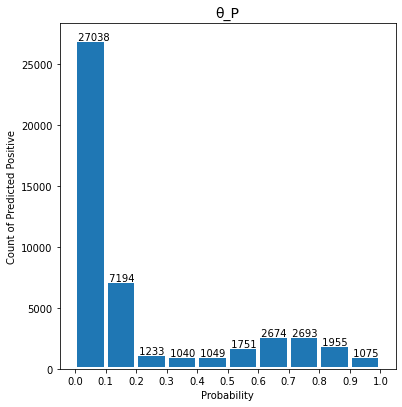

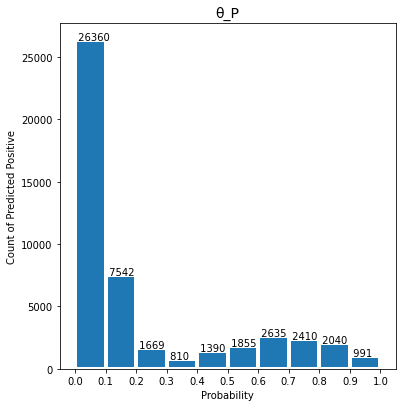

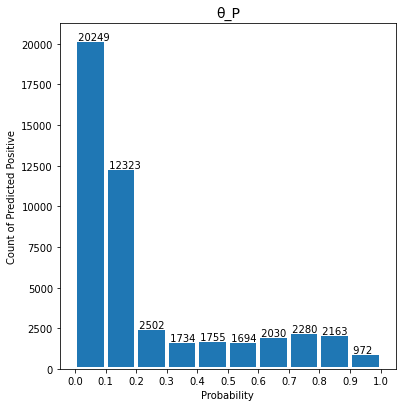

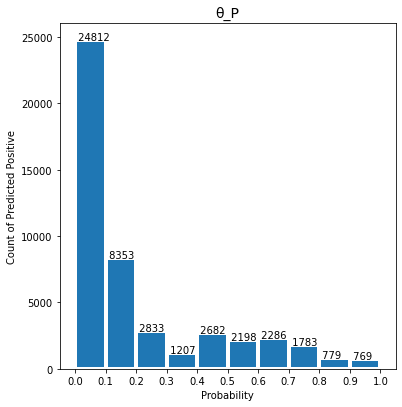

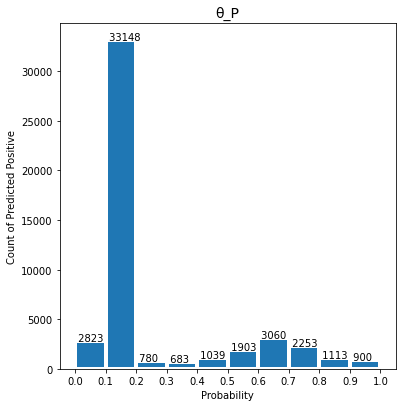

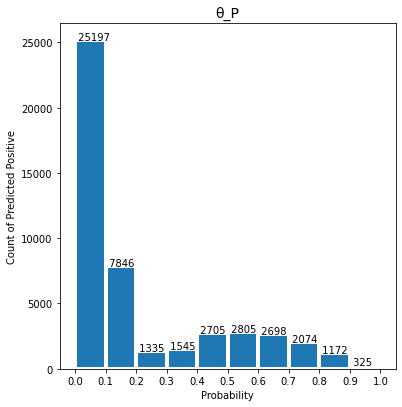

In [19]:
import numpy as np
import matplotlib.pyplot as plt

cols = []
for model in models:
  modelname = str(model).split('(')[0]
  #print(modelname)
  prob_0 = modelname + '_prob_0'
  prob_positive = modelname + '_prob_positive'

  fig = plt.figure(figsize=(14, 6))
  plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.9,
                      top=0.9,
                      wspace=0.4,
                      hspace=0.4)

  arr1 = fig.add_subplot(1, 2, 1)

  ## Plot histograms
  df_p1 = final_PU[[prob_positive]].copy()

  custom_bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
  bl=len(custom_bins)-1

  arr1.set_xlabel('Probability')
  arr1.set_ylabel('Count of Predicted Positive')
  arr1.set_xticks(np.arange(0, 1.1, step=0.10))
  #arr1.grid()
  #arr1.set_title(prob_positive, fontsize = 14)
  arr1.set_title('θ_P', fontsize = 14)

  arr1=plt.hist(df_p1[prob_positive],bins=custom_bins,edgecolor='white', linewidth=4)
  for i in range(bl):
      plt.text(arr1[1][i],arr1[0][i],str(' ') + str(int(arr1[0][i])), fontsize=10)

In [20]:
del df_p1

In [21]:
# Create positive/Negative Labels using VotingClassifier probabilities
# VotingClassifier_prob_positive > "threshold" is treated as Positive Label (labeled as "1")

#-----------------------------------------------------------------------#
#Setting the threshold here changes the True Positives & True Negatives
threshold = 0.7
#-----------------------------------------------------------------------#

final_PU['Predicted_Class'] = 0
final_PU['Predicted_Class'] = [1 if x > threshold else 0 for x in final_PU['VotingClassifier_prob_positive']]

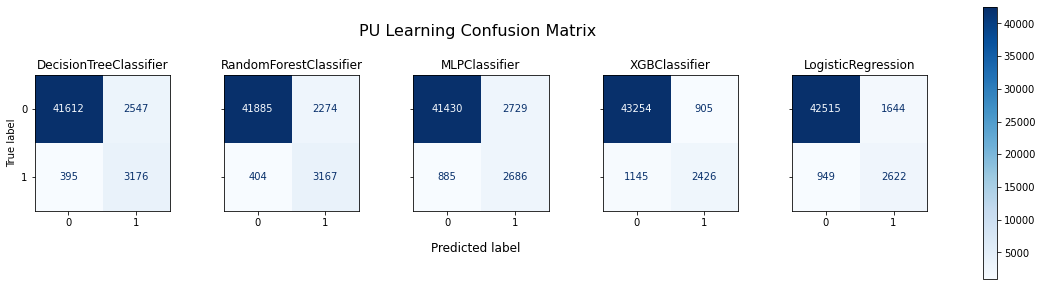

In [22]:
## Model Validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

i=0
f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')  # Use for 5 classifiers

# Since VT is treated as True Prediction, omit it from "models" list by using models[:-1]
for model in models[:-1]:
  modelname = str(model).split('(')[0]
  y = final_PU['Predicted_Class']
  ypred= [1 if x > threshold else 0 for x in final_PU[modelname + '_prob_positive']]

  cm = confusion_matrix(y, ypred)
  cm_display = ConfusionMatrixDisplay(cm)
  cm_display.plot(ax=axes[i],cmap='Blues')
  cm_display.ax_.set_title(modelname)
  cm_display.im_.colorbar.remove()
  cm_display.ax_.set_xlabel('')
  if i!=0:
    cm_display.ax_.set_ylabel('')
  i +=1

f.text(0.35, 0.8, 'PU Learning Confusion Matrix', ha='left',fontsize=16)
f.text(0.4, 0.2, 'Predicted label', ha='left',fontsize=12)
plt.subplots_adjust(wspace=0.40, hspace=0.3)
f.colorbar(cm_display.im_, ax=axes)

In [23]:
del y
del ypred

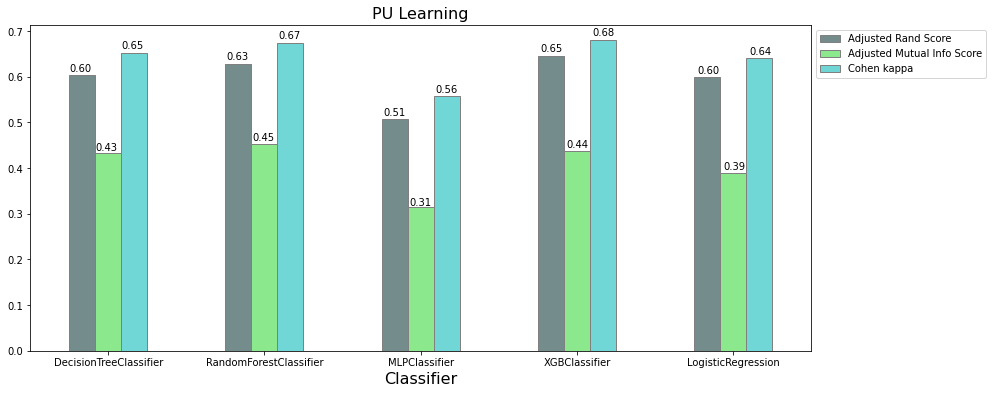

In [24]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

def ARI(labels_true, labels_pred):
  return adjusted_rand_score(labels_true, labels_pred)

def AMI(labels_true, labels_pred):
  return adjusted_mutual_info_score(labels_true, labels_pred)

def kappa(labels_true, labels_pred):
  return cohen_kappa_score(labels_true, labels_pred)

i=0
Classifier = []
ARI_Score = []
AMI_Score = []
kappa_Score = []

# Since VT is treated as True Prediction, omit it from "models" list by using models[:-1]
for model in models[:-1]:
  modelname = str(model).split('(')[0]
  y = final_PU['Predicted_Class']
  ypred= [1 if x > threshold else 0 for x in final_PU[modelname + '_prob_positive']]
  Classifier.append(modelname)
  ARI_Score.append(ARI(y, ypred))
  AMI_Score.append(AMI(y, ypred))
  kappa_Score.append(kappa(y, ypred)) 
df_score = pd.DataFrame(list(zip(Classifier, ARI_Score, AMI_Score, kappa_Score)))
df_score.columns = ['Classifier','Adjusted Rand Score','Adjusted Mutual Info Score', 'Cohen kappa']

#Set Custom Colors
c1 = (0.4, 0.5, 0.5, 0.9)
c2 = (0.5, 0.9, 0.5, 0.9)
c3 = (0.3, 0.8, 0.8, 0.8)

ax=df_score.set_index('Classifier').plot.bar(color={"Adjusted Rand Score": c1, "Adjusted Mutual Info Score": c2, "Cohen kappa": c3}, rot=0,edgecolor = "gray")
ax.figure.set_size_inches(14,6)
ax.set_xlabel('Classifier', fontsize=16)
ax.set_title('PU Learning', fontsize=16)
ax.legend(bbox_to_anchor=(1.23, 1.0))

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.015))

In [25]:
del y
del ypred

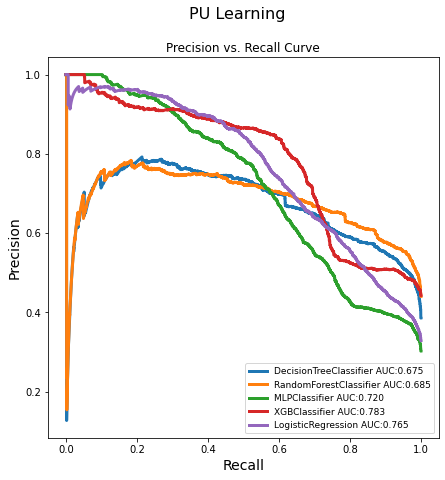

In [26]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

i=0
plt.figure(figsize=(7, 7))
for model in models[:-1]:
  modelname = str(model).split('(')[0]
  y = final_PU['Predicted_Class']
  ypred = final_PU[modelname + '_prob_positive'].fillna(0).values
  prec, recall, _ = precision_recall_curve(y, ypred)
  pr_auc = auc(recall, prec)
  plt.plot(recall, prec, lw=3, label=(modelname + ' AUC:' + '{:.3f}'.format(pr_auc)))
  i +=1
plt.xlabel("Recall",fontsize=14)
plt.ylabel("Precision",fontsize=14)
plt.rcParams['font.size'] = '9'

plt.legend(loc="best")
plt.title("Precision vs. Recall Curve", fontsize=12)
plt.suptitle("PU Learning", fontsize=16)
plt.show()

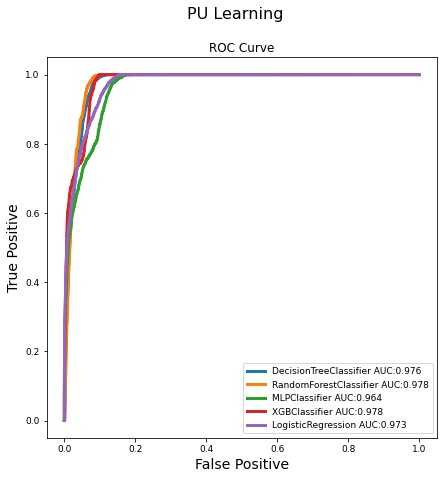

In [27]:
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve

i=0
plt.figure(figsize=(7, 7))
for model in models[:-1]:
  modelname = str(model).split('(')[0]
  y = final_PU['Predicted_Class']
  ypred = final_PU[modelname + '_prob_positive'].fillna(0).values
  fpr, tpr, _ = roc_curve(y, ypred)
  roc_auc = roc_auc_score(y, ypred)
  plt.plot(fpr, tpr, lw=3, label=(modelname + ' AUC:' + '{:.3f}'.format(roc_auc)))
  i +=1
plt.xlabel("False Positive", fontsize=14)
plt.ylabel("True Positive", fontsize=14)
plt.rcParams['font.size'] = '9'
plt.legend(loc="best")
plt.title("ROC Curve", fontsize=12)
plt.suptitle("PU Learning", fontsize=16)
plt.show()

In [28]:
del y
del ypred

In [29]:
df_rsid = pd.read_csv("/content/drive/MyDrive/Regeneron_STS_2023/Model/Input_Data/FINAL_Full33Columns_start_end.txt", header=0, delimiter = '\t',
                      usecols = ['chromosome','start','end','RSID'], 
                      dtype={'chromosome': str, 'start': int, 'end': int, 'RSID': str})
df_rsid

,chromosome,start,end,RSID
0,chr1,229820,229821,rs1159884564
1,chr1,529825,529826,rs888953847
2,chr1,531142,531143,rs1040232850
3,chr1,566327,566328,rs1390538076
4,chr1,581537,581538,rs1250812823
...,...,...,...,...
21016300,chrY,21154538,21154539,rs906942985
21016301,chrY,21154545,21154546,rs1003742204
21016302,chrY,21154790,21154791,rs1049274273
21016303,chrY,24435146,24435147,rs1233237655


In [30]:
df_final_PU = pd.merge(final_PU, df_rsid, how='left', left_on=['chr','start','end'], right_on=['chromosome','start','end'])
del df_rsid

In [31]:
df_final_PU.head()

,chr,start,end,xc119_TPM,xc120_TPM,Nreads,score,score_ATAC_wtcMG,score_chip_invitro,score_chip_exvivo,...,MLPClassifier_prob_positive,XGBClassifier_prob_0,XGBClassifier_prob_positive,LogisticRegression_prob_0,LogisticRegression_prob_positive,VotingClassifier_prob_0,VotingClassifier_prob_positive,Predicted_Class,chromosome,RSID
0,chr1,916549,916550,0.00,0.00,0.0,0.00,0.066223,0.00000,0.0,...,0.135681,0.869627,0.130373,0.874896,0.125104,0.907939,0.092061,0,chr1,rs6660139
1,chr1,961827,961828,20.37,18.24,6.8,8.67,0.110371,0.00000,0.0,...,0.467397,0.185334,0.814666,0.396027,0.603973,0.304934,0.695066,0,chr1,rs3121556
2,chr1,963249,963250,20.37,18.24,6.8,8.67,0.066223,0.03043,0.0,...,0.465396,0.454419,0.545581,0.397733,0.602267,0.482295,0.517705,0,chr1,rs2710870
3,chr1,971224,971225,20.37,18.24,6.8,8.67,0.154519,0.00000,0.0,...,0.639936,0.305440,0.694560,0.228201,0.771799,0.285408,0.714592,1,chr1,rs2799055
4,chr1,972134,972135,20.37,18.24,6.8,8.67,0.033111,0.03043,0.0,...,0.609812,0.741196,0.258804,0.248714,0.751286,0.549146,0.450854,0,chr1,rs3121575


In [32]:
del final_PU

# NU Predictions Processing

In [33]:
import pandas as pd
model_pred = [
'NU_predictions_DecisionTreeClassifier.txt',
'NU_predictions_RandomForestClassifier.txt',
'NU_predictions_MLPClassifier.txt',
'NU_predictions_XGBClassifier.txt',
'NU_predictions_LogisticRegression.txt',
'NU_predictions_VotingClassifier.txt'
]

df_prob_list = []
for pred in model_pred:
  filename = '/content/drive/My Drive/Regeneron_STS_2023/Model/' + pred
  df = pd.read_csv(filename,delimiter='\t')
  df_prob_list.append(df)

In [34]:
## Flatten the df_prob_list - list of probability dataframes for all models
all_predicted_proba = pd.concat(df_prob_list, axis=1)
all_predicted_proba.head()

,0,1,0,1,0,1,0,1,0,1,0,1
0,0.409485,0.590515,0.431470,0.568530,0.575008,0.424992,0.543379,0.456621,0.692802,0.307198,0.526676,0.473324
1,0.116064,0.883936,0.114146,0.885854,0.181801,0.818199,0.122281,0.877719,0.134424,0.865576,0.133145,0.866855
2,0.191979,0.808021,0.202747,0.797253,0.186741,0.813259,0.211364,0.788636,0.135598,0.864402,0.183719,0.816281
3,0.137941,0.862059,0.126905,0.873095,0.159332,0.840668,0.204754,0.795246,0.145829,0.854171,0.154322,0.845678
4,0.645208,0.354792,0.630470,0.369530,0.193165,0.806835,0.701554,0.298446,0.158035,0.841965,0.467248,0.532752


In [35]:
## Add column names to flattened dataframe

cols = []
for model in models:
  modelname = str(model).split('(')[0]
  #print(modelname)
  cols.append(modelname + '_prob_0')
  cols.append(modelname + '_prob_negative')

all_predicted_proba.columns = cols
all_predicted_proba.head()

,DecisionTreeClassifier_prob_0,DecisionTreeClassifier_prob_negative,RandomForestClassifier_prob_0,RandomForestClassifier_prob_negative,MLPClassifier_prob_0,MLPClassifier_prob_negative,XGBClassifier_prob_0,XGBClassifier_prob_negative,LogisticRegression_prob_0,LogisticRegression_prob_negative,VotingClassifier_prob_0,VotingClassifier_prob_negative
0,0.409485,0.590515,0.431470,0.568530,0.575008,0.424992,0.543379,0.456621,0.692802,0.307198,0.526676,0.473324
1,0.116064,0.883936,0.114146,0.885854,0.181801,0.818199,0.122281,0.877719,0.134424,0.865576,0.133145,0.866855
2,0.191979,0.808021,0.202747,0.797253,0.186741,0.813259,0.211364,0.788636,0.135598,0.864402,0.183719,0.816281
3,0.137941,0.862059,0.126905,0.873095,0.159332,0.840668,0.204754,0.795246,0.145829,0.854171,0.154322,0.845678
4,0.645208,0.354792,0.630470,0.369530,0.193165,0.806835,0.701554,0.298446,0.158035,0.841965,0.467248,0.532752


In [36]:
del df_prob_list

In [37]:
## Drop Positive Labels to convert data into NU-Learning Dataset
mod_data = df_N[df_N['Target'] != 1].copy()

mod_data = mod_data[['xc119_TPM','xc120_TPM','cnt_ovr_exptd','Nreads','score',
                 'score_ATAC_wtcMG','score_chip_invitro','score_chip_exvivo',
                 'score_atac_exvivo','score_atac_invitro','eQTL_flg','index1','Target']].copy()
print(mod_data['Target'].value_counts())

-1    47702
 2       14
Name: Target, dtype: int64


In [38]:
df=pd.read_csv('/content/drive/My Drive/Regeneron_STS_2023/Model/Input_Data/SSL_PUNU_Model_Input_Final.txt',header=0, sep='\t')
#df.head()

## Create final dataframe by joining fattened probabilities frame to original input dataset
tmp1 = mod_data[mod_data['Target']==-1][['index1']].copy()
tmp1.reset_index(drop=True, inplace=True)
tmp2 = mod_data.loc[~mod_data['index1'].isin(tmp1['index1'])][['index1']].copy()
dp = all_predicted_proba.copy()
dp.reset_index(drop=True, inplace=True)
tmp1[ list(dp.columns) ] = dp
tmp3 = tmp1.append(tmp2)
tmp4 = pd.merge(df_N, tmp3, on=['index1'],how='left').sort_values('index1')
tmp4.pop('index1')
tmp5 = df[['chr','start','end']].copy()
final_NU = tmp5.join(tmp4, how='inner')
final_NU.head()

,chr,start,end,xc119_TPM,xc120_TPM,Nreads,score,score_ATAC_wtcMG,score_chip_invitro,score_chip_exvivo,...,RandomForestClassifier_prob_0,RandomForestClassifier_prob_negative,MLPClassifier_prob_0,MLPClassifier_prob_negative,XGBClassifier_prob_0,XGBClassifier_prob_negative,LogisticRegression_prob_0,LogisticRegression_prob_negative,VotingClassifier_prob_0,VotingClassifier_prob_negative
0,chr1,916549,916550,0.00,0.00,0.0,0.00,0.066223,0.00000,0.0,...,0.431470,0.568530,0.575008,0.424992,0.543379,0.456621,0.692802,0.307198,0.526676,0.473324
1,chr1,961827,961828,20.37,18.24,6.8,8.67,0.110371,0.00000,0.0,...,0.114146,0.885854,0.181801,0.818199,0.122281,0.877719,0.134424,0.865576,0.133145,0.866855
2,chr1,963249,963250,20.37,18.24,6.8,8.67,0.066223,0.03043,0.0,...,0.202747,0.797253,0.186741,0.813259,0.211364,0.788636,0.135598,0.864402,0.183719,0.816281
3,chr1,971224,971225,20.37,18.24,6.8,8.67,0.154519,0.00000,0.0,...,0.126905,0.873095,0.159332,0.840668,0.204754,0.795246,0.145829,0.854171,0.154322,0.845678
4,chr1,972134,972135,20.37,18.24,6.8,8.67,0.033111,0.03043,0.0,...,0.630470,0.369530,0.193165,0.806835,0.701554,0.298446,0.158035,0.841965,0.467248,0.532752


In [39]:
del df
del tmp1
del tmp2
del tmp3
del tmp4
del tmp5
del dp

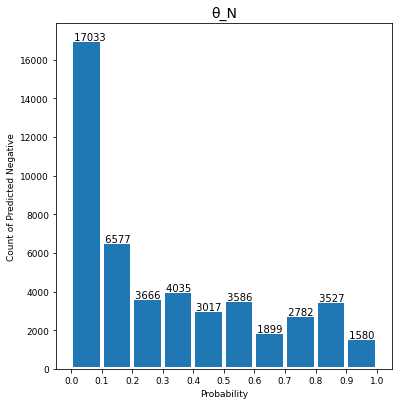

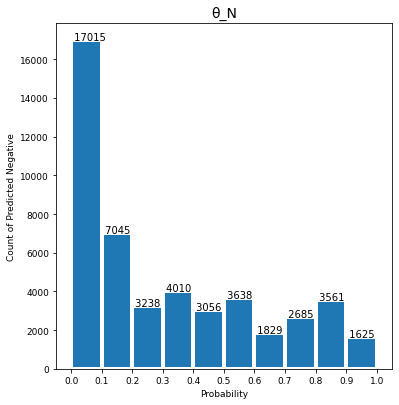

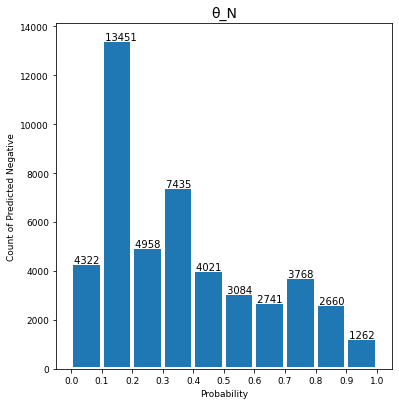

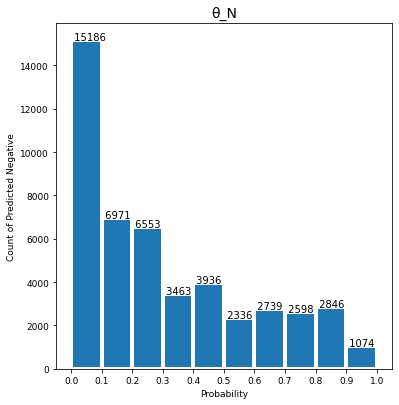

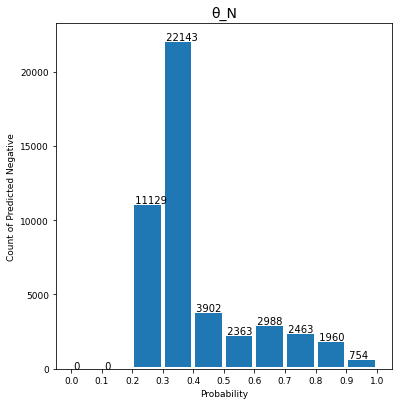

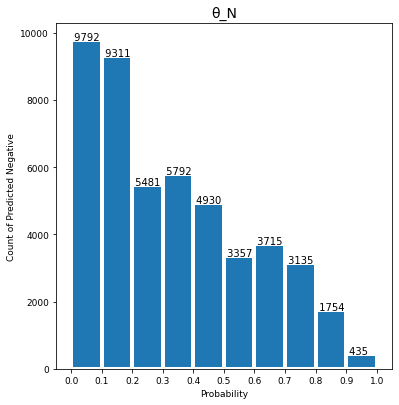

In [40]:
#import matplotlib.pylab as plt
import numpy as np
import matplotlib.pyplot as plt

cols = []
for model in models:
  modelname = str(model).split('(')[0]
  #print(modelname)
  prob_0 = modelname + '_prob_0'
  prob_negative = modelname + '_prob_negative'
  fig = plt.figure(figsize=(14, 6))
  plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.9,
                      top=0.9,
                      wspace=0.4,
                      hspace=0.4)

  arr1 = fig.add_subplot(1, 2, 1)

  ## Plot histograms
  df_p1 = final_NU[[prob_negative]].copy()

  custom_bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
  bl=len(custom_bins)-1

  arr1.set_xlabel('Probability')
  arr1.set_ylabel('Count of Predicted Negative')
  arr1.set_xticks(np.arange(0, 1.1, step=0.10))
  #arr1.grid()
  #arr1.set_title(prob_negative, fontsize = 14)
  arr1.set_title('θ_N', fontsize = 14)

  arr1=plt.hist(df_p1[prob_negative],bins=custom_bins,edgecolor='white', linewidth=4)
  for i in range(bl):
      plt.text(arr1[1][i],arr1[0][i],str(' ') + str(int(arr1[0][i])), fontsize=10)

In [41]:
del df_p1

In [42]:
# Create positive/Negative Labels using VotingClassifier probabilities
# VotingClassifier_prob_negative > "threshold" is treated as Negative Label (labeled as "2")
#-----------------------------------------------------------------------#
#Setting the threshold here changes the True Negatives
threshold = 0.6
#-----------------------------------------------------------------------#

final_NU['Predicted_Class'] = 0
final_NU['Predicted_Class'] = [1 if x > threshold else 0 for x in final_NU['VotingClassifier_prob_negative']]

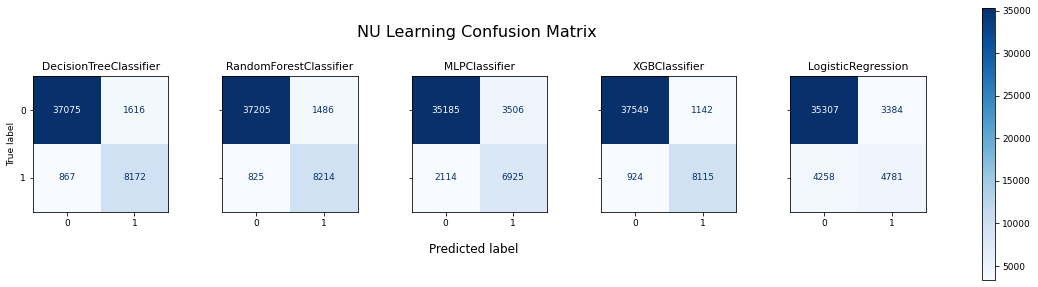

In [43]:
## Model Validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

i=0
f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')  # Use for 5 classifiers

# Since VT is treated as True Prediction, omit it from "models" list by using models[:-1]
for model in models[:-1]:
  modelname = str(model).split('(')[0]
  y = final_NU['Predicted_Class']
  ypred= [1 if x > threshold else 0 for x in final_NU[modelname + '_prob_negative']]
  cm = confusion_matrix(y, ypred)
  cm_display = ConfusionMatrixDisplay(cm)
  cm_display.plot(ax=axes[i],cmap='Blues')
  cm_display.ax_.set_title(modelname)
  cm_display.im_.colorbar.remove()
  cm_display.ax_.set_xlabel('')
  if i!=0:
    cm_display.ax_.set_ylabel('')
  i +=1

f.text(0.35, 0.8, 'NU Learning Confusion Matrix', ha='left',fontsize=16)
f.text(0.4, 0.2, 'Predicted label', ha='left',fontsize=12)
plt.subplots_adjust(wspace=0.40, hspace=0.3)
f.colorbar(cm_display.im_, ax=axes)

In [44]:
del y
del ypred

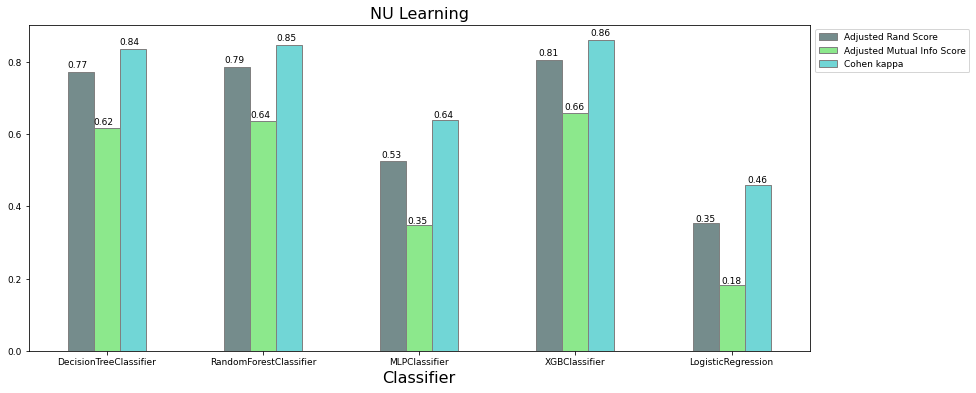

In [45]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

def ARI(labels_true, labels_pred):
  return adjusted_rand_score(labels_true, labels_pred)

def AMI(labels_true, labels_pred):
  return adjusted_mutual_info_score(labels_true, labels_pred)

def kappa(labels_true, labels_pred):
  return cohen_kappa_score(labels_true, labels_pred)

i=0
Classifier = []
ARI_Score = []
AMI_Score = []
kappa_Score = []

# Since VT is treated as True Prediction, omit it from "models" list by using models[:-1]
for model in models[:-1]:
  modelname = str(model).split('(')[0]
  y = final_NU['Predicted_Class']
  ypred= [1 if x > threshold else 0 for x in final_NU[modelname + '_prob_negative']]
  Classifier.append(modelname)
  ARI_Score.append(ARI(y, ypred))
  AMI_Score.append(AMI(y, ypred))
  kappa_Score.append(kappa(y, ypred)) 
df_score = pd.DataFrame(list(zip(Classifier, ARI_Score, AMI_Score, kappa_Score)))
df_score.columns = ['Classifier','Adjusted Rand Score','Adjusted Mutual Info Score', 'Cohen kappa']

# Custom Colors
c1 = (0.4, 0.5, 0.5, 0.9)
c2 = (0.5, 0.9, 0.5, 0.9)
c3 = (0.3, 0.8, 0.8, 0.8)
ax=df_score.set_index('Classifier').plot.bar(color={"Adjusted Rand Score": c1, "Adjusted Mutual Info Score": c2, "Cohen kappa": c3}, rot=0,edgecolor = "gray")

ax.figure.set_size_inches(14,6)
ax.set_xlabel('Classifier', fontsize=16)
ax.set_title('NU Learning', fontsize=16)
ax.legend(bbox_to_anchor=(1.21, 1.0))

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.015))

In [46]:
del y
del ypred

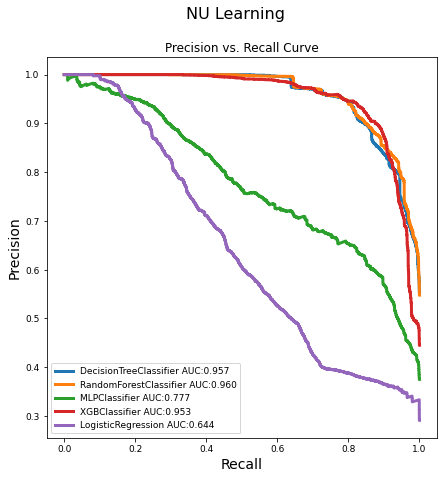

In [47]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

i=0
plt.figure(figsize=(7, 7))
for model in models[:-1]:
  modelname = str(model).split('(')[0]
  y = final_NU['Predicted_Class']
  ypred = final_NU[modelname + '_prob_negative'].fillna(0).values
  prec, recall, _ = precision_recall_curve(y, ypred)
  pr_auc = auc(recall, prec)
  plt.plot(recall, prec, lw=3, label=(modelname + ' AUC:' + '{:.3f}'.format(pr_auc)))
  i +=1
plt.xlabel("Recall",fontsize=14)
plt.ylabel("Precision",fontsize=14)
plt.rcParams['font.size'] = '9'

plt.legend(loc="best")
plt.title("Precision vs. Recall Curve", fontsize=12)
plt.suptitle("NU Learning", fontsize=16)
plt.show()

In [48]:
del y
del ypred

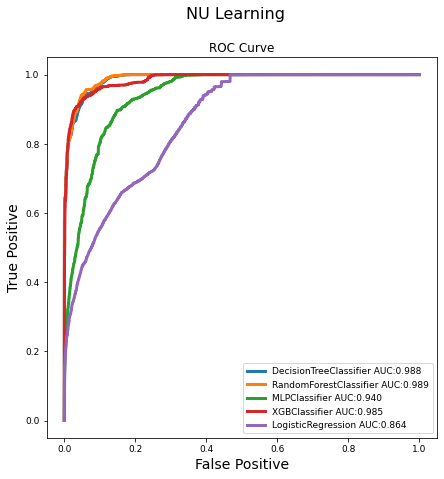

In [49]:
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve

i=0
plt.figure(figsize=(7, 7))
for model in models[:-1]:
  modelname = str(model).split('(')[0]
  y = final_NU['Predicted_Class']
  ypred = final_NU[modelname + '_prob_negative'].fillna(0).values
  fpr, tpr, _ = roc_curve(y, ypred)
  roc_auc = roc_auc_score(y, ypred)
  plt.plot(fpr, tpr, lw=3, label=(modelname + ' AUC:' + '{:.3f}'.format(roc_auc)))
  i +=1
plt.xlabel("False Positive", fontsize=14)
plt.ylabel("True Positive", fontsize=14)
plt.rcParams['font.size'] = '9'
plt.legend(loc="best")
plt.title("ROC Curve", fontsize=12)
plt.suptitle("NU Learning", fontsize=16)
plt.show()

In [50]:
del y
del ypred

In [51]:
df_rsid = pd.read_csv("/content/drive/MyDrive/Regeneron_STS_2023/Model/Input_Data/FINAL_Full33Columns_start_end.txt", header=0, delimiter = '\t',
                      usecols = ['chromosome','start','end','RSID'], 
                      dtype={'chromosome': str, 'start': int, 'end': int, 'RSID': str})
df_rsid

,chromosome,start,end,RSID
0,chr1,229820,229821,rs1159884564
1,chr1,529825,529826,rs888953847
2,chr1,531142,531143,rs1040232850
3,chr1,566327,566328,rs1390538076
4,chr1,581537,581538,rs1250812823
...,...,...,...,...
21016300,chrY,21154538,21154539,rs906942985
21016301,chrY,21154545,21154546,rs1003742204
21016302,chrY,21154790,21154791,rs1049274273
21016303,chrY,24435146,24435147,rs1233237655


In [52]:
df_final_NU = pd.merge(final_NU, df_rsid, how='left', left_on=['chr','start','end'], right_on=['chromosome','start','end'])
df_final_NU.head()

,chr,start,end,xc119_TPM,xc120_TPM,Nreads,score,score_ATAC_wtcMG,score_chip_invitro,score_chip_exvivo,...,MLPClassifier_prob_negative,XGBClassifier_prob_0,XGBClassifier_prob_negative,LogisticRegression_prob_0,LogisticRegression_prob_negative,VotingClassifier_prob_0,VotingClassifier_prob_negative,Predicted_Class,chromosome,RSID
0,chr1,916549,916550,0.00,0.00,0.0,0.00,0.066223,0.00000,0.0,...,0.424992,0.543379,0.456621,0.692802,0.307198,0.526676,0.473324,0,chr1,rs6660139
1,chr1,961827,961828,20.37,18.24,6.8,8.67,0.110371,0.00000,0.0,...,0.818199,0.122281,0.877719,0.134424,0.865576,0.133145,0.866855,1,chr1,rs3121556
2,chr1,963249,963250,20.37,18.24,6.8,8.67,0.066223,0.03043,0.0,...,0.813259,0.211364,0.788636,0.135598,0.864402,0.183719,0.816281,1,chr1,rs2710870
3,chr1,971224,971225,20.37,18.24,6.8,8.67,0.154519,0.00000,0.0,...,0.840668,0.204754,0.795246,0.145829,0.854171,0.154322,0.845678,1,chr1,rs2799055
4,chr1,972134,972135,20.37,18.24,6.8,8.67,0.033111,0.03043,0.0,...,0.806835,0.701554,0.298446,0.158035,0.841965,0.467248,0.532752,0,chr1,rs3121575


In [53]:
del df_rsid
del final_NU

# Combine df_final_PU and df_final_NU

In [54]:
df_final_PUNU = pd.concat([df_final_PU, df_final_NU[['VotingClassifier_prob_negative']]], axis=1).copy()

In [55]:
df_final_PUNU.columns

Index(['chr', 'start', 'end', 'xc119_TPM', 'xc120_TPM', 'Nreads', 'score',
       'score_ATAC_wtcMG', 'score_chip_invitro', 'score_chip_exvivo',
       'score_atac_exvivo', 'score_atac_invitro', 'eQTL_flg', 'Target',
       'cnt_ovr_exptd', 'DecisionTreeClassifier_prob_0',
       'DecisionTreeClassifier_prob_positive', 'RandomForestClassifier_prob_0',
       'RandomForestClassifier_prob_positive', 'MLPClassifier_prob_0',
       'MLPClassifier_prob_positive', 'XGBClassifier_prob_0',
       'XGBClassifier_prob_positive', 'LogisticRegression_prob_0',
       'LogisticRegression_prob_positive', 'VotingClassifier_prob_0',
       'VotingClassifier_prob_positive', 'Predicted_Class', 'chromosome',
       'RSID', 'VotingClassifier_prob_negative'],
      dtype='object')

In [56]:
df_final_PUNU = df_final_PUNU[['chr', 'start', 'end', 'RSID',
                               'xc119_TPM', 'xc120_TPM', 'Nreads', 'score',
                               'score_ATAC_wtcMG', 'score_chip_invitro', 'score_chip_exvivo',
                               'score_atac_exvivo', 'score_atac_invitro', 'eQTL_flg',
                               'cnt_ovr_exptd','VotingClassifier_prob_positive', 'Predicted_Class',
                               'VotingClassifier_prob_negative']].copy()

In [ ]:
#del df_final_PU
#del df_final_NU

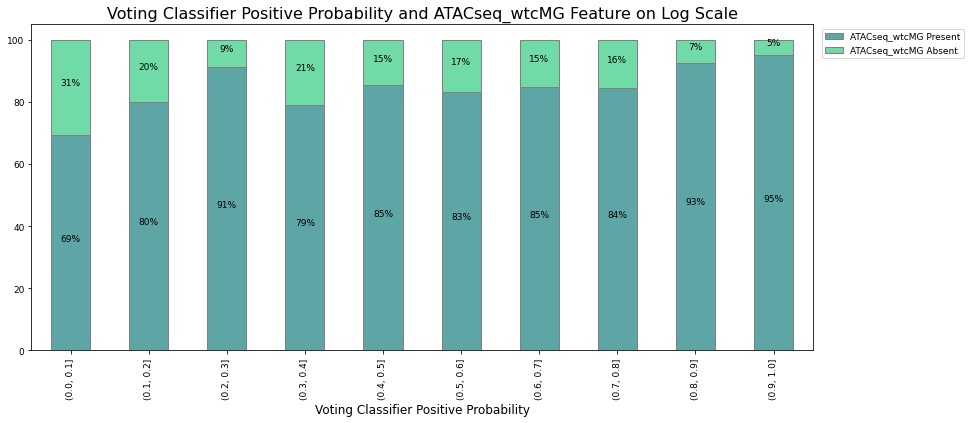

In [59]:
bins = np.arange(0,1.1,0.1)
df_p1 =df_final_PUNU[['VotingClassifier_prob_positive','score_ATAC_wtcMG']].copy()
df_p1['ATACseq_wtcMG_Flg'] = [1 if x > 0 else 0 for x in df_p1['score_ATAC_wtcMG']]
                             
df_p1_eQ = df_p1.groupby( [pd.cut( df_p1['VotingClassifier_prob_positive'], bins),'ATACseq_wtcMG_Flg'] ).count()['VotingClassifier_prob_positive'].to_frame()
df_p1_eQ = pd.DataFrame(df_p1_eQ.unstack(level=-1))
df_p1_eQ.columns = ['ATACseq_wtcMG Absent Count', 'ATACseq_wtcMG Present Count']

df_p1_eQ['ATACseq_wtcMG Absent'] = df_p1_eQ['ATACseq_wtcMG Absent Count'].div(df_p1_eQ['ATACseq_wtcMG Present Count'] + df_p1_eQ['ATACseq_wtcMG Absent Count'] )*100
df_p1_eQ['ATACseq_wtcMG Present'] = 100 - df_p1_eQ['ATACseq_wtcMG Absent Count'].div(df_p1_eQ['ATACseq_wtcMG Present Count'] + df_p1_eQ['ATACseq_wtcMG Absent Count'] )*100

df_p1_eQ = df_p1_eQ[['ATACseq_wtcMG Present', 'ATACseq_wtcMG Absent']].copy()

# Custom Colors
c1 = (0.1, 0.5, 0.5, 0.7)
c2 = (0.2, 0.8, 0.5, 0.7)
my_colors = [c1, c2]
ax = df_p1_eQ.plot.bar(figsize=(14,6),log=False,color=my_colors,edgecolor='gray',stacked=True)
ax.set_title("Voting Classifier Positive Probability and ATACseq_wtcMG Feature on Log Scale",fontsize=16)
ax.set_xlabel("Voting Classifier Positive Probability",fontsize=12)
ax.legend(bbox_to_anchor=(1.2, 1.0))

for rec in ax.patches:
    height = rec.get_height()
    ax.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

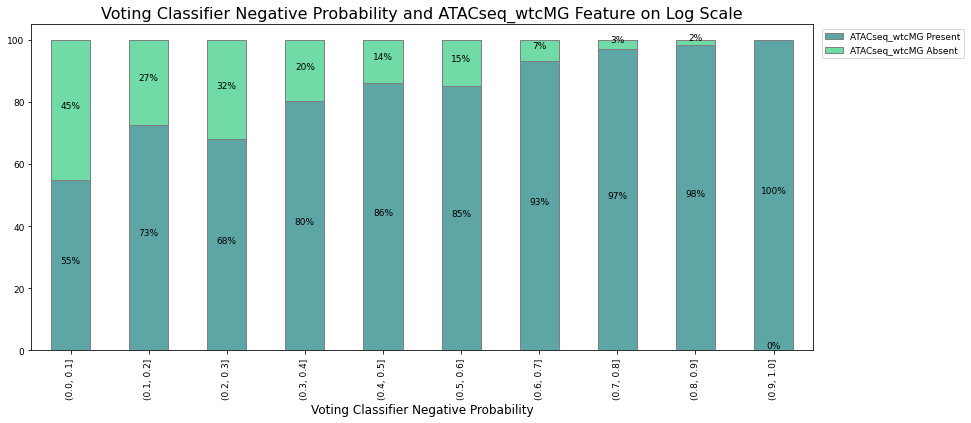

In [60]:
bins = np.arange(0,1.1,0.1)
df_p1 =df_final_PUNU[['VotingClassifier_prob_negative','score_ATAC_wtcMG']].copy()
df_p1['ATACseq_wtcMG_Flg'] = [1 if x > 0 else 0 for x in df_p1['score_ATAC_wtcMG']]
                             
df_p1_eQ = df_p1.groupby( [pd.cut( df_p1['VotingClassifier_prob_negative'], bins),'ATACseq_wtcMG_Flg'] ).count()['VotingClassifier_prob_negative'].to_frame()
df_p1_eQ = pd.DataFrame(df_p1_eQ.unstack(level=-1))
df_p1_eQ.columns = ['ATACseq_wtcMG Absent Count', 'ATACseq_wtcMG Present Count']

df_p1_eQ['ATACseq_wtcMG Absent'] = df_p1_eQ['ATACseq_wtcMG Absent Count'].div(df_p1_eQ['ATACseq_wtcMG Present Count'] + df_p1_eQ['ATACseq_wtcMG Absent Count'] )*100
df_p1_eQ['ATACseq_wtcMG Present'] = 100 - df_p1_eQ['ATACseq_wtcMG Absent Count'].div(df_p1_eQ['ATACseq_wtcMG Present Count'] + df_p1_eQ['ATACseq_wtcMG Absent Count'] )*100

df_p1_eQ = df_p1_eQ[['ATACseq_wtcMG Present', 'ATACseq_wtcMG Absent']].copy()

# Custom Colors
c1 = (0.1, 0.5, 0.5, 0.7)
c2 = (0.2, 0.8, 0.5, 0.7)
my_colors = [c1, c2]
ax = df_p1_eQ.plot.bar(figsize=(14,6),log=False,color=my_colors,edgecolor='gray',stacked=True)
ax.set_title("Voting Classifier Negative Probability and ATACseq_wtcMG Feature on Log Scale",fontsize=16)
ax.set_xlabel("Voting Classifier Negative Probability",fontsize=12)
ax.legend(bbox_to_anchor=(1.2, 1.0))

for rec in ax.patches:
    height = rec.get_height()
    ax.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

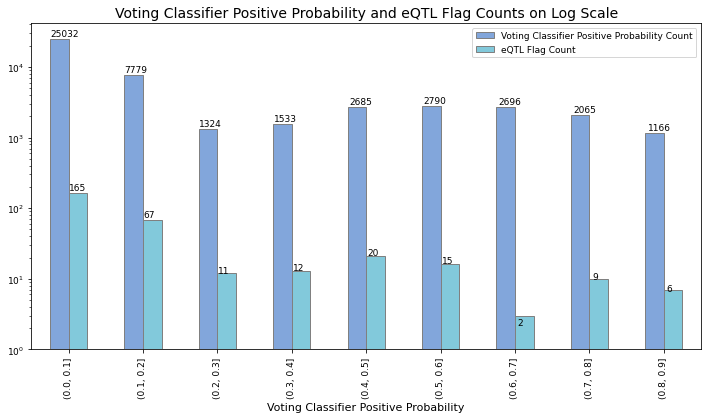

In [61]:
bins = np.arange(0,1,0.1)
df_p1 =df_final_PUNU[['VotingClassifier_prob_positive','eQTL_flg']].copy()
df_p1_eQ = df_p1.groupby( [pd.cut( df_p1['VotingClassifier_prob_positive'], bins),'eQTL_flg'] ).count()['VotingClassifier_prob_positive'].to_frame()

df_p1_eQ = pd.DataFrame(df_p1_eQ.unstack(level=-1))
df_p1_eQ.columns = ['Voting Classifier Positive Probability Count', 'eQTL Flag Count']

# Custom Colors
c1 = (0.3, 0.5, 0.8, 0.7)
c2 = (0.3, 0.7, 0.8, 0.7)
my_colors = [c1, c2]
ax = df_p1_eQ.plot.bar(figsize=(12,6),log=True,color=my_colors,edgecolor='gray')
ax.set_title("Voting Classifier Positive Probability and eQTL Flag Counts on Log Scale",fontsize=14)
ax.set_xlabel("Voting Classifier Positive Probability",fontsize=11)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.1))

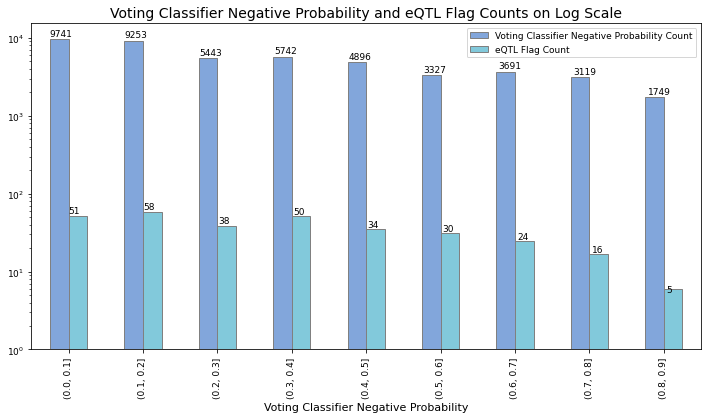

In [62]:
bins = np.arange(0,1,0.1)
df_p1 =df_final_PUNU[['VotingClassifier_prob_negative','eQTL_flg']].copy()
df_p1_eQ = df_p1.groupby( [pd.cut( df_p1['VotingClassifier_prob_negative'], bins),'eQTL_flg'] ).count()['VotingClassifier_prob_negative'].to_frame()

df_p1_eQ = pd.DataFrame(df_p1_eQ.unstack(level=-1))
df_p1_eQ.columns = ['Voting Classifier Negative Probability Count', 'eQTL Flag Count']

# Custom Colors
c1 = (0.3, 0.5, 0.8, 0.7)
c2 = (0.3, 0.7, 0.8, 0.7)
my_colors = [c1, c2]
ax = df_p1_eQ.plot.bar(figsize=(12,6),log=True,color=my_colors,edgecolor='gray')
ax.set_title("Voting Classifier Negative Probability and eQTL Flag Counts on Log Scale",fontsize=14)
ax.set_xlabel("Voting Classifier Negative Probability",fontsize=11)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.1))

In [63]:
del df_p1
del df_p1_eQ

In [64]:
# Visualization
import plotly.express as px
import plotly.graph_objects as go
#import matplotlib.patches as patches

# Create a scatter plot
#fig = px.scatter(df_final_PUNU, x='VotingClassifier_prob_positive', y='VotingClassifier_prob_negative', opacity=0.5,
#                 color='VotingClassifier_prob_positive')

fig = px.scatter(df_final_PUNU, x='VotingClassifier_prob_positive', y='VotingClassifier_prob_negative', opacity=0.5
                 )

#fig.add_shape(type="rect",
#    x0=0.7, y0=0.3, x1=0.9, y1=0.4,
#    line=dict(
#        color="black",
#        width=1
#    ),
#    #fillcolor="LightSkyBlue",
#)

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',title='Voting Classifier Positive Probability')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',title='Voting Classifier Negative Probability')

# Set figure title
fig.update_layout(title_text="Predicted Positive vs. Predicted Negative")

# Update marker size
fig.update_traces(marker=dict(size=5))

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


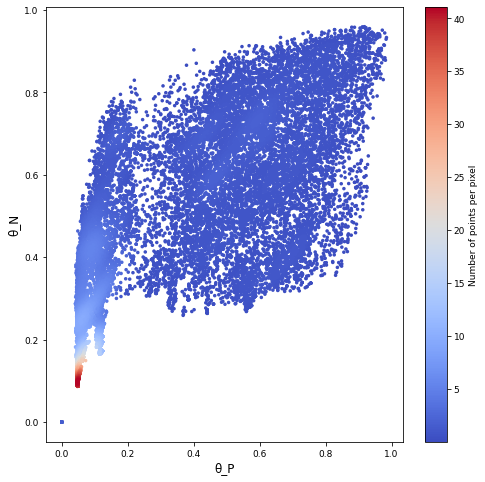

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
import matplotlib.colors as mplc
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

x = df_final_PUNU['VotingClassifier_prob_positive'].values
y = df_final_PUNU['VotingClassifier_prob_negative'].values

x[np.isnan(x)]=0
y[np.isnan(y)]=0

fig, ax = plt.subplots(figsize=(8,8))
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)                                           
# Sort the points by density, so that the densest points are       
# plotted last                                                     
idx = z.argsort()                                                  
x2, y2, z = x[idx], y[idx], z[idx]                                 
s = ax.scatter(                                                     
    x2, y2, c=z, s=50, cmap='coolwarm', marker='.',
    edgecolor='', label=None, picker=True, zorder=2                
) 
ax.set_xlabel('θ_P',fontsize=12)
ax.set_ylabel('θ_N',fontsize=12)
fig.colorbar(s, label='Number of points per pixel')


#marker='.' alpha=0.8,

In [ ]:
positive_threshold = 0.7
negative_threshold = 0.4

df_final_PUNU[(df_final_PUNU['VotingClassifier_prob_positive'] > positive_threshold) & 
              (df_final_PUNU['VotingClassifier_prob_negative'] < negative_threshold)].sort_values('VotingClassifier_prob_positive',ascending=False)

,chr,start,end,RSID,xc119_TPM,xc120_TPM,Nreads,score,score_ATAC_wtcMG,score_chip_invitro,score_chip_exvivo,score_atac_exvivo,score_atac_invitro,eQTL_flg,cnt_ovr_exptd,VotingClassifier_prob_positive,Predicted_Class,VotingClassifier_prob_negative
45854,chr8,90822759,90822760,rs28144,0.0,0.0,15.000000,7.326667,0.000000,0.0,0.0,0.0,0.050722,0,0.000000,0.849017,1,0.383821
25897,chr2,127882342,127882343,rs72838226,0.0,0.0,12.000000,6.150000,0.022074,0.0,0.0,0.0,0.050722,0,0.000000,0.848547,1,0.378327
2332,chr1,207799874,207799875,rs10863420,0.0,0.0,13.428571,7.065714,0.000000,0.0,0.0,0.0,0.050722,0,0.000000,0.848163,1,0.390980
21403,chr19,16376632,16376633,rs191517111,0.0,0.0,15.000000,7.240000,0.000000,0.0,0.0,0.0,0.050722,0,0.000000,0.844685,1,0.381561
23420,chr19,45812918,45812919,rs192559160,0.0,0.0,12.666667,6.423333,0.022074,0.0,0.0,0.0,0.050722,0,0.000000,0.839570,1,0.387036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40191,chr6,34707861,34707862,rs2814962,0.0,0.0,23.000000,6.920000,0.011037,0.0,0.0,0.0,0.050722,0,0.000000,0.703431,1,0.365854
40192,chr6,34707885,34707886,rs59474093,0.0,0.0,23.000000,6.920000,0.011037,0.0,0.0,0.0,0.050722,0,0.000000,0.703353,1,0.365914
22332,chr19,45306923,45306924,rs140086276,0.0,0.0,21.000000,7.220000,0.011037,0.0,0.0,0.0,0.050722,0,2.706718,0.703313,1,0.399317
14160,chr16,23545711,23545712,rs6497673,0.0,0.0,15.000000,5.420000,0.000000,0.0,0.0,0.0,0.050722,0,0.000000,0.702573,1,0.324263


In [ ]:
df_Final155_Variants = df_final_PUNU[(df_final_PUNU['VotingClassifier_prob_positive'] > positive_threshold) & 
                                     (df_final_PUNU['VotingClassifier_prob_negative'] < negative_threshold)].sort_values('VotingClassifier_prob_positive',ascending=False).copy()
df_Final155_Variants = df_Final155_Variants[['chr','start','end','RSID','Nreads',
                                             'score','score_ATAC_wtcMG','eQTL_flg',
                                             'VotingClassifier_prob_positive','Predicted_Class',
                                             'VotingClassifier_prob_negative']].copy()

In [ ]:
del df_N

# Feature Importance

In [ ]:
import pandas as pd
model_feature = [
'PU_feature_importance_DecisionTreeClassifier.txt',
'PU_feature_importance_RandomForestClassifier.txt',
'PU_feature_importance_MLPClassifier.txt',
'PU_feature_importance_XGBClassifier.txt',
'PU_feature_importance_LogisticRegression.txt',
'PU_feature_importance_VotingClassifier.txt'
]

In [ ]:
df_feature_list = []
for feature in model_feature:
  filename = '/content/drive/My Drive/Regeneron_STS_2023/Model/' + feature
  df = pd.read_csv(filename,delimiter='\t')
  df_feature_list.append(df)

In [ ]:
feature_name = ['RNA-seq119','RNA-seq120','PLAC-seq','pcHic_Nreads',
                'pcHic-score','ATAC-seq-wtcMG','H3k27ac-Chipseq-invitro',
                'H3k27ac-Chipseq-exvivo','ATACseq-exvivo','ATACseq-invitro','eQTL']

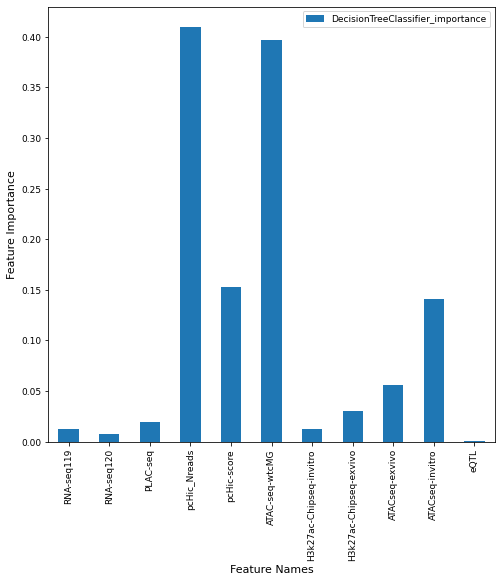

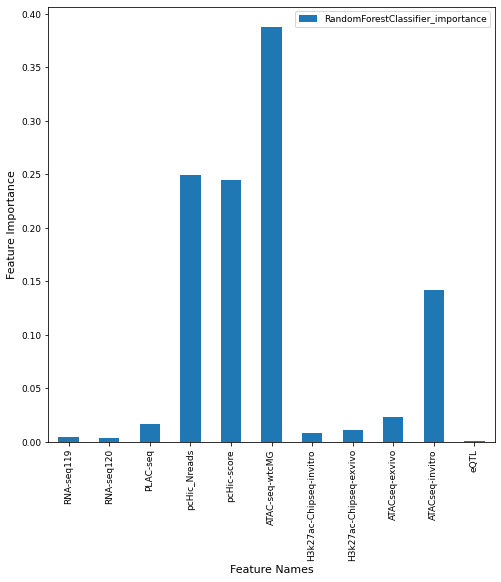

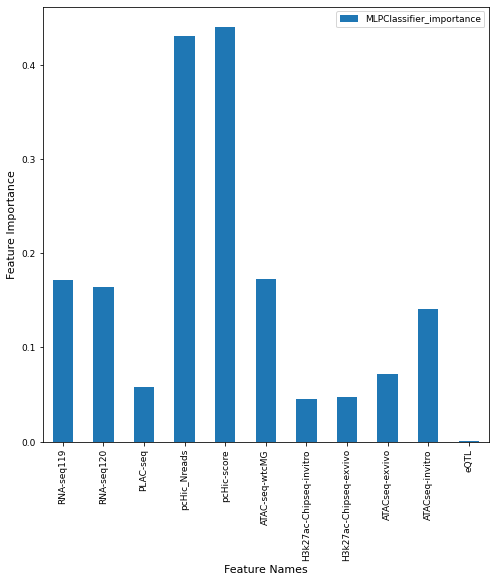

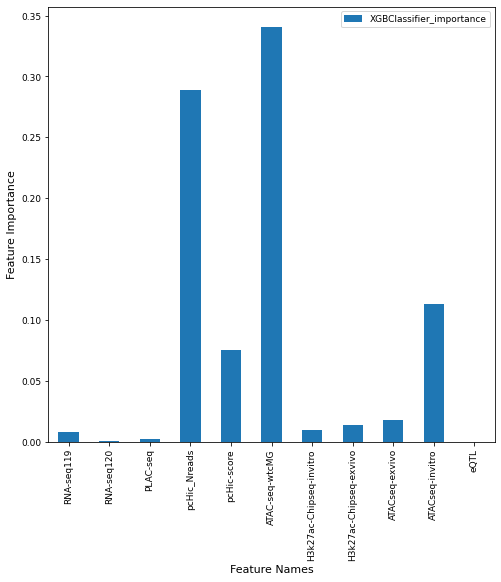

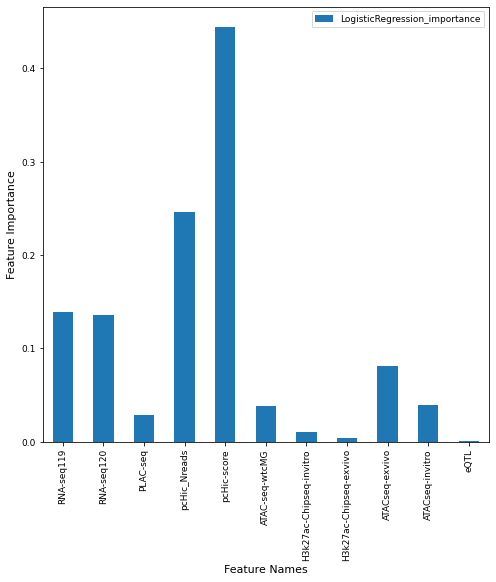

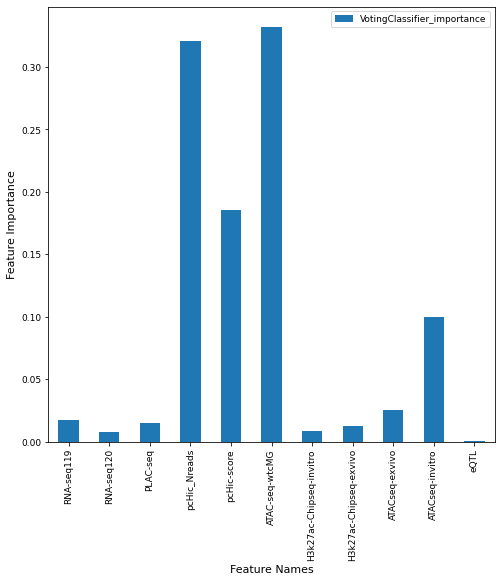

In [ ]:
cols=[]
for idx, model in enumerate(models):
    #print(idx, model)
    modelname = str(model).split('(')[0]
    #print(modelname)
    cols=[]
    cols.append(modelname + '_feature')
    cols.append(modelname + '_importance')
    cols.append(modelname + '_std')
    df_feature_list[idx].columns = cols
    df_plot = df_feature_list[idx]

    df_plot['Feature'] = feature_name
    ax = df_plot.plot.bar(x='Feature', y=modelname + '_importance',figsize=(8,8))
    ax.set_xlabel("Feature Names",fontsize=11)
    ax.set_ylabel("Feature Importance",fontsize=11)
    plt.hspace=15